In [1]:
from Agama_Spray_stream import *
from scipy.interpolate import CubicSpline
from sklearn.mixture import GaussianMixture

# seed = 7

# rng = np.random.RandomState(seed)

# logM, Rs = 12., 15.
# q = 0.5
# dirx, diry, dirz = rng.normal(size=3)
# dirz = np.abs(dirz)

# logm, rs = 8., 1.

# x0, y0, z0    = rng.normal(size=3) * 100
# vx0, vy0, vz0 = rng.normal(size=3) * 100

# t_end = 4 # Gyr


# params = np.array([logM, Rs, q, dirx, diry, dirz, logm, rs, x0, y0, z0, vx0, vy0, vz0, t_end])

seed = 7 #np.random.randint(100)
data, params = getData(seed)
xy_streams = model(params)

x = xy_streams[:,0]
y = xy_streams[:,1]
r = np.sqrt(x**2 + y**2)
theta = np.arctan2(y, x)
theta[theta<0] += 2*np.pi

time unit: 0.978 Gyr


In [2]:
log_likelihood(params, data)

-19.822165934025843

In [3]:
theta_bin = np.linspace(0, 2*np.pi, 18)

theta_data = []
r_data = []
r_sig = []
for i in range(len(theta_bin)-1):
    idx = np.where((theta>theta_bin[i]) & (theta<theta_bin[i+1]))[0]

    if len(idx) > 10:
        gmm1 = GaussianMixture(n_components=1, covariance_type='full', random_state=42).fit(r[idx].reshape(-1,1))

        r_data.append(gmm1.means_[0][0])
        r_sig.append(np.sqrt(gmm1.covariances_[0][0][0]))
        theta_data.append((theta_bin[i]+theta_bin[i+1])/2.)
r_data = np.array(r_data)
r_sig = np.array(r_sig)
theta_data = np.array(theta_data)
x_data = r_data*np.cos(theta_data)
y_data = r_data*np.sin(theta_data)

dict_data = {'r':r_data, 'theta':theta_data, 'r_sig':r_sig, 'x':x_data, 'y':y_data}

(-74.50565338134766, 69.99304962158203, -143.35474395751953, 89.72034454345703)

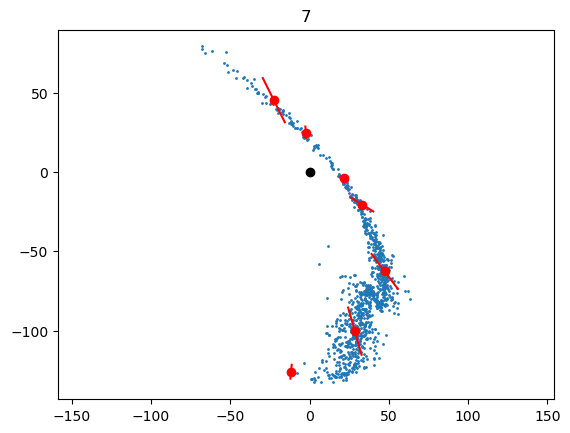

In [4]:
plt.title(seed)
plt.scatter(xy_streams[:, 0], xy_streams[:, 1], s=1)#, c=xhi)
plt.scatter(x_data, y_data, c='r')
for i in range(len(theta_data)):
    xerr = r_sig[i] * np.cos(theta_data[i])
    yerr = r_sig[i] * np.sin(theta_data[i])
    plt.plot([x_data[i] - xerr, x_data[i] + xerr], [y_data[i] - yerr, y_data[i] + yerr], 'r')
plt.scatter(0, 0, c='k')
plt.axis('equal') 

In [4]:
xy_streams.shape

(1000, 2)

Define the LIKELIHOOD

Text(0.5, 1.0, '-2e+50')

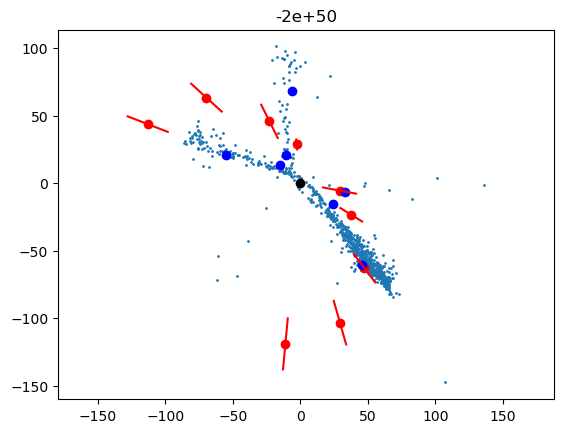

In [21]:
ndim = 15
p = np.random.uniform(size=ndim)
params = prior_transform(p)
# params = np.array([logM, Rs, q, dirx, diry, dirz, logm, rs, x0, y0, z0, vx0, vy0, vz0, t_end])

xy_streams = model(params)

x_model = xy_streams[:,0]
y_model = xy_streams[:,1]
r_model = np.sqrt(x_model**2 + y_model**2)
theta_model = np.arctan2(y_model, x_model)
theta_model[theta_model<0] += 2*np.pi

r_data = dict_data['r']
theta_data = dict_data['theta']
delta_theta_data = np.diff(theta_data).min()/2
r_sig = dict_data['r_sig']

logl = 0
x_fit = []
y_fit = []

for index, i in enumerate( np.unique(theta_data) ):
    idx_data  = np.where(theta_data==i)[0] 

    # if (index == 0) or (index == len(theta_data)-1):
    #     idx_model = np.where( (theta_model>i-delta_theta_data[index]) & (theta_model<i+delta_theta_data[index]))[0]
    # elif index == len(theta_data)-1:
    #     idx_model = np.where( (theta_model>i-delta_theta_data[index-1]) & (theta_model<i+delta_theta_data[index-1]))[0]
    # else:
    #     idx_model = np.where( (theta_model>i-delta_theta_data[index-1]) & (theta_model<i+delta_theta_data[index]))[0]

    
    idx_model = np.where( (theta_model>i-delta_theta_data) & (theta_model<i+delta_theta_data))[0]

    if len(idx_model) >= 10:
        gmm_fit = GaussianMixture(n_components=len(idx_data), covariance_type='full', random_state=42).fit(r_model[idx_model].reshape(-1,1))
        r_fit = gmm_fit.means_.flatten()
        x_fit.extend(r_fit*np.cos(i))
        y_fit.extend(r_fit*np.sin(i))
        logl += -0.5*np.sum( (np.sort(r_data[idx_data]) - np.sort(r_fit))**2/r_sig[idx_data]**2 + np.log(r_sig[idx_data]**2) )        
    else:
        logl += -BAD_VAL

plt.scatter(xy_streams[:, 0], xy_streams[:, 1], s=1)#, c=xhi)
plt.scatter(x_data, y_data, c='r')
plt.scatter(x_fit, y_fit, c='b')
for i in range(len(theta_data)):
    xerr = r_sig[i] * np.cos(theta_data[i])
    yerr = r_sig[i] * np.sin(theta_data[i])
    plt.plot([x_data[i] - xerr, x_data[i] + xerr], [y_data[i] - yerr, y_data[i] + yerr], 'r')
plt.scatter(0, 0, c='k')
plt.axis('equal') 
plt.title(logl)

In [76]:
theta_data

array([1.66319611, 2.03279525, 2.40239438, 2.77199352, 4.6199892 ,
       4.98958833, 5.35918747, 5.7287866 , 6.09838574])

In [77]:
np.diff(theta_data)

array([0.36959914, 0.36959914, 0.36959914, 1.84799568, 0.36959914,
       0.36959914, 0.36959914, 0.36959914])